# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
#Import all libraries needed at first for cleaner and clearer code
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from copy import deepcopy
import random
import time
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from scipy.stats import norm
import pylab as pyl
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,DotProduct,Matern,RationalQuadratic,WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, SGDClassifier, RidgeClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, f_classif
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict, cross_val_score, cross_validate, GroupShuffleSplit, KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc, make_scorer, plot_precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.patches as patches

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [3]:
from scipy import stats
import numpy as np
#Check if there are outliers
z = np.abs(stats.zscore(X))
threshold = 3
print(len(np.where(z > 3)) > 0)

True


In [4]:
#Normalize feature data
#TODO: MinMaxScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)
X.shape

(180, 432)

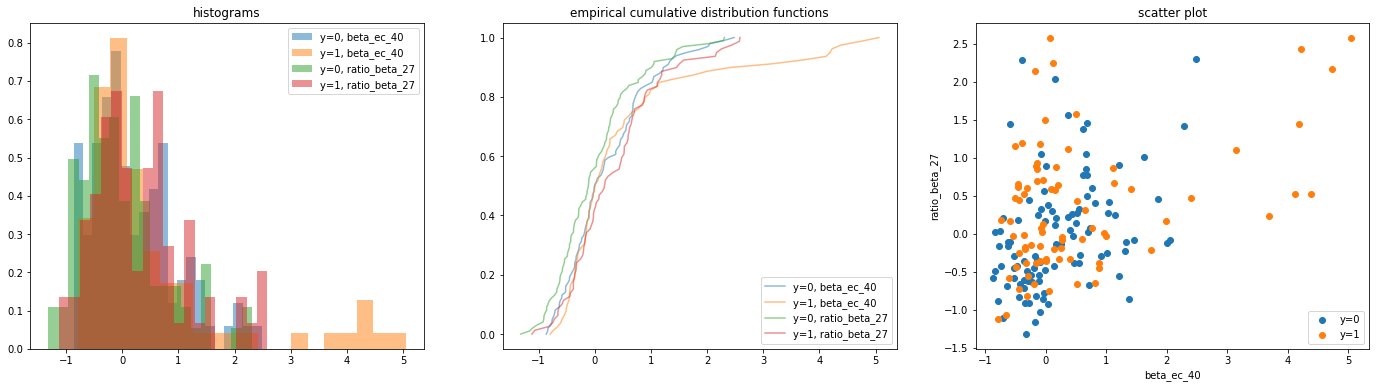

In [5]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

<b>Step 1:</b><br>
Data Analysis and exploration

In [6]:
# Extract data as dataframe to explore later on
features = pd.DataFrame(data=X, columns=feature_names)

In [7]:
#Check for NaN values:
features.isnull().values.any()

False

Combine features based on waves:

In [8]:
#Alpha, beta and theta waves for eyes open
alpha_eo = features.iloc[:,0:48]
beta_eo = features.iloc[:,48:48*2]
theta_eo = features.iloc[:,48*2:48*3]
#Alpha, beta and theta waves for eyes closed
alpha_ec = features.iloc[:,48*3:48*4]
beta_ec = features.iloc[:,48*4:48*5]
theta_ec = features.iloc[:,48*5:48*6]
#Ratio for alpha beta and theta eyes open/ eyes closed
alpha_r = features.iloc[:,48*6:48*7]
beta_r = features.iloc[:,48*7:48*8]
theta_r = features.iloc[:,48*8:48*9]
#Add all features in a list for ease of manipulation
independent_variables = [alpha_eo,alpha_ec,alpha_r,beta_eo,beta_ec,beta_r,theta_eo,theta_ec,theta_r]

Text(0, 0.5, 'Waves')

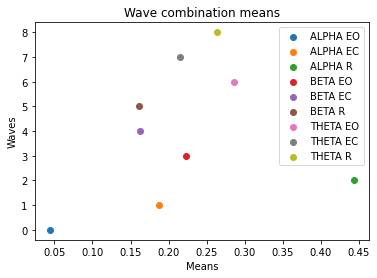

In [9]:
#Get the means of each feature and plot them
means = []
colormap = np.array(['k', 'b', 'r','m','c','r','y','m','r'])
y_ax = range(0,len(independent_variables))
plt.figure()
for feature in independent_variables:
    means.append(np.mean(feature.values))
# comb = plt.scatter(range(0,len(independent_variables)),means,c=colormap)
w0 = plt.scatter(np.mean(independent_variables[0].values), y_ax[0])
w1 = plt.scatter(np.mean(independent_variables[1].values), y_ax[1])
w2 = plt.scatter(np.mean(independent_variables[2].values), y_ax[2])
w3 = plt.scatter(np.mean(independent_variables[3].values), y_ax[3])
w4 = plt.scatter(np.mean(independent_variables[4].values), y_ax[4])
w5 = plt.scatter(np.mean(independent_variables[5].values), y_ax[5])
w6 = plt.scatter(np.mean(independent_variables[6].values), y_ax[6])
w7 = plt.scatter(np.mean(independent_variables[7].values), y_ax[7])
w8 = plt.scatter(np.mean(independent_variables[8].values), y_ax[8])
plt.legend((w0,w1,w2,w3,w4,w5,w6,w7,w8),
           ("ALPHA EO", "ALPHA EC","ALPHA R","BETA EO","BETA EC","BETA R","THETA EO","THETA EC","THETA R"))
plt.title("Wave combination means")
plt.xlabel("Means")
plt.ylabel("Waves")

In [10]:
#Calculate correlation matrix to check the values of between 0 and 1 of all features, it would be a good idea
#to eliminate features that are highly correlated
corr_matrix = features.corr(method = "spearman").abs()

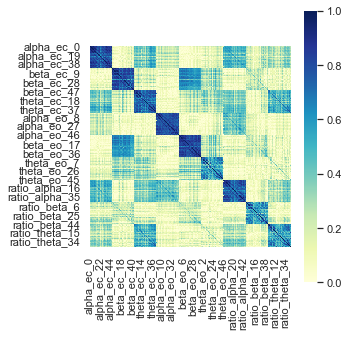

In [11]:
# Draw the heatmap on some examples
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()

In [12]:
alpha_waves = independent_variables[0].join(independent_variables[1]).join(
    independent_variables[2]).join(
    pd.DataFrame(y,columns=["labels"]))

beta_waves = independent_variables[3].join(independent_variables[4]).join(
    independent_variables[5]).join(
    pd.DataFrame(y,columns=["labels"]))

theta_waves = independent_variables[6].join(independent_variables[7]).join(
    independent_variables[8]).join(
    pd.DataFrame(y,columns=["labels"]))

<b>ALPHA WAVES</b>

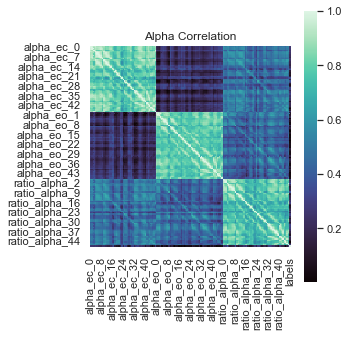

In [13]:
alpha_corr = alpha_waves.corr(method="spearman").abs()
# Draw the heatmap on alpha waves
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(alpha_corr, square=True, ax = ax, cmap="mako").set_title("Alpha Correlation")
f.tight_layout()

<b>BETA WAVES CORRELATION</b>

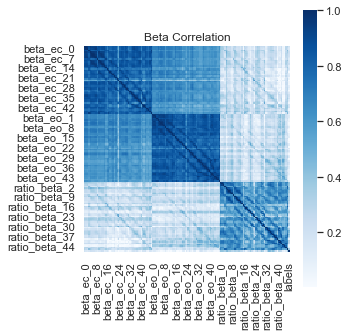

In [14]:
beta_corr = beta_waves.corr(method="spearman").abs()
# Draw the heatmap on beta waves
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(beta_corr, square=True, ax = ax, cmap="Blues").set_title("Beta Correlation")
f.tight_layout()

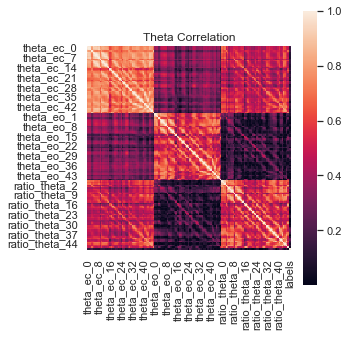

In [15]:
theta_corr = theta_waves.corr(method="spearman").abs()
# Draw the heatmap on theta waves
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(theta_corr, square=True, ax = ax).set_title("Theta Correlation")
f.tight_layout()

From the correlation maps above, we can see that some features within the waves are highly correlated together, hence working as some kind of duplication of information.

<b>Step 2:</b> Feature engineering + Result Testing<br>
In this step, we will test some feature engineering methods to reduce feature dimensions in order to achieve higher performance.

In [16]:
#Since the experiments needs one subject out, we will group every 9 rows as a subject

groups = np.zeros(180).astype(int)

counter = 0
subject = 0

while(counter < 180):
    if(counter%10==0 and counter !=0):
        subject+=1
    groups[counter] = subject
    counter+=1

In [17]:
#Group splits
groups

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

In [18]:
#This dataframe will hold the different results from the different methods used
results_final = pd.DataFrame()

In [19]:
score_names = ['Accuracy Mean','Accuracy Std','Specificity','Sensitivity','AUC Score', 'Execution Time (s)','Number of Features']

<b>Part 0:</b> Baseline

In [20]:
y[y == 0] = -1 #Perform for SVM output of {-1,1}

In [21]:
#Set seed for random number generator
random.seed(42)

In [22]:
#Prepare array to save roc curves of different methods
roc_curves = []

In [23]:
# # Set Grid search parameters for SGD classifier
grid_params_SGD = {'alpha' : [0.001,0.003,0.004,0.005,0.006,0.007,0.008,0.009, 0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1, 1]}

In [24]:
#Group split used for cross validation:
LOGO = LeaveOneGroupOut()

Build Functions:

In [25]:
#This method will be used for ease of extracting the different metrics from the confusion matrix
def get_scores(cm, y_preds):
    
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    sp = TN/(TN + FP)
    se = TP/(TP + FN)
    f, t, th = roc_curve(y, y_preds)

    auc_score = auc(f,t)
    
    return [0,0,sp, se, auc_score]

In [26]:
#Prepare general method for predicting y labels excluding baseline:

def predict(X, y, cv, groups, model = None):
    
    print(f"{X.shape[1]} Features")
    
    if(not model):
        
        cv_b = LOGO.split(X,y,groups)

        #Create the GridSearchCV object

        grid_clf = GridSearchCV(SGDClassifier(early_stopping=True, n_iter_no_change=2,loss = "modified_huber",
                               tol=0.0001,validation_fraction=0.2,random_state=42,n_jobs=-1),grid_params_SGD, cv=cv_b, n_jobs=-1)
        grid_clf.fit(X, y)

        model_params = grid_clf.best_params_

        #Print the best parameters

        print(f"Best Parameters: {model_params}")
            
        model = SGDClassifier(early_stopping=True,loss = "modified_huber", 
                              n_iter_no_change=2,
                              tol=0.0001, 
                              validation_fraction=0.2,
                              alpha=model_params['alpha'],random_state=42, n_jobs=-1)
    trains = []
    tests = []
    
    #Calculate train/test score to check for overfitting
    
    y_tests = []
    y_predictions = []
    for train_idx, test_idx in LOGO.split(X,y,groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_p_train = model.predict(X_train)
        train_acc = model.score(X_train, y_train)
        y_p_test = model.predict(X_test)
        test_acc = model.score(X_test, y_test)
        trains.append(train_acc)
        tests.append(test_acc)
        
    print("Train accuracy: " + str(np.mean((trains))))
    print("Test accuracy: " + str(np.mean(tests)))
    
    #Extract important metrics
    
    cv_0 = cv.split(X, y, groups)

    accuracy = cross_val_score(model, X, y, cv=cv_0, n_jobs=-1)

    cv_1 = cv.split(X, y, groups)

    y_preds = cross_val_predict(model, X, y, cv=cv_1, n_jobs=-1)

    cv_2 = cv.split(X, y, groups)

    y_preds_proba = cross_val_predict(model, X, y, cv = cv_2, method = "predict_proba")

    fpr, tpr, _ = roc_curve(y,y_preds_proba[:,1])

    cm = confusion_matrix(y, y_preds)
    
    return y_preds, cm, fpr, tpr, accuracy, model, trains, tests

In [27]:
#Prepare method for filtering X and reducing dimensions:
def filter(X, y, groups, f_type, cv, model=None):
    
    cv_base = cv.split(X, y, groups)

    N_FEATURES_OPTIONS = range(0,X.shape[1],20)

    anova = SelectKBest(score_func=f_type)
    #If model is passed, use its best parameters, otherwise perform grid search on new reduced X and find best k features
    if(not model):
        #Parametsr to tune:
        param = {'reduce_dim': [anova], 
                 'reduce_dim__k': N_FEATURES_OPTIONS,
                 'classify__alpha': [0.001,0.003,0.004,0.005,0.006,0.007,0.008,0.009, 0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1]}
        #Main pipeline:
        pipe = Pipeline(steps=[('reduce_dim','passthrough'), ('classify', SGDClassifier(early_stopping=True,
                                                                                        loss = "modified_huber", 
                                                                                        n_iter_no_change=2,
                                                                                        tol=0.0001, 
                                                                                        validation_fraction=0.2,
                                                                                        random_state=42,
                                                                                       n_jobs=-1))])
    
    else:
        
        param = {'reduce_dim': [anova],
                 'reduce_dim__k': N_FEATURES_OPTIONS}

        pipe = Pipeline(steps=[('reduce_dim','passthrough'), ('classify', model)])

    grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param, cv=cv_base, scoring="accuracy")

    grid.fit(deepcopy(X),y)

    #After getting the best k number of features based on accuracy score, we will use it and get all metrics.
    best_k = grid.best_params_["reduce_dim__k"]

    filter_best = SelectKBest(score_func=f_type,k=best_k)

    X_reduced = filter_best.fit_transform(deepcopy(X),y)
    
    if(not model):
    
        model_params = grid.best_params_['classify__alpha']

        print(f"{X_reduced.shape[1]} features")
        
    else:
        
        model_params = None
        
    #Return reduced features and best model parameters
    
    return X_reduced, model_params

432 Features
Best Parameters: {'alpha': 0.05}
Train accuracy: 0.9209150326797384
Test accuracy: 0.8555555555555555


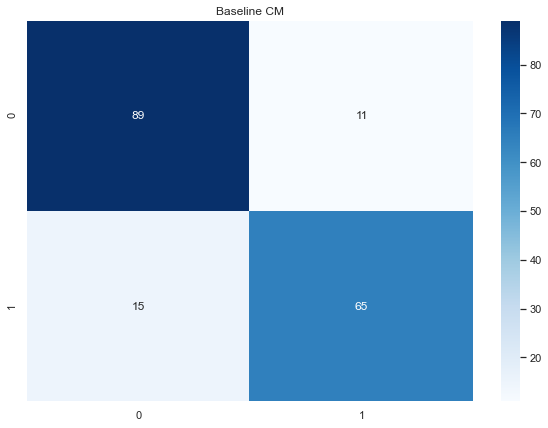

In [28]:
#Baseline Code:
start_time = time.time()

y_preds_base, cm_base, fpr_base, tpr_base, accuracy_base, model_base, trains_base, tests_base = predict(X, y, LOGO, groups)

mean_acc_base = np.mean(accuracy_base)

std_acc_base = np.std(accuracy_base)

plt.figure(figsize = (10,7))

plt.title("Baseline CM")

sns.heatmap(cm_base, annot=True,cmap="Blues")

#Get necessary metrics for table

scores_base = get_scores(cm_base, y_preds_base)

scores_base[0] = mean_acc_base

scores_base[1] = std_acc_base

execution_time = time.time() - start_time

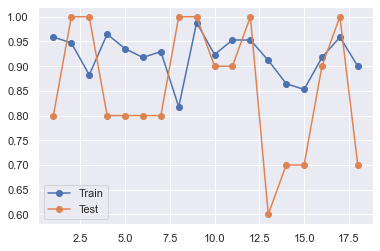

In [29]:
#Plot train and test scores on method
folds = [i for i in range(1, 19)]
plt.plot(folds, trains_base, '-o', label='Train')
plt.plot(folds, tests_base, '-o', label='Test')
plt.legend()
plt.show()

In [30]:
#Add results of baseline to aggregating table
scores_base.append(execution_time)
scores_base.append(int(X.shape[1]))
results_final["Baseline"] = scores_base
results_final.index = score_names

In [31]:
#We can see that the baseline method has room for improvement.
results_final

,Baseline
Accuracy Mean,0.855556
Accuracy Std,0.125708
Specificity,0.855263
Sensitivity,0.855769
AUC Score,0.851250
Execution Time (s),6.067074
Number of Features,432.000000


<b>Part 1:</b> Filtering Methods

<b>Method 1:</b> Correlation Filter

In [32]:
#Drop features with correlation > 95%
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduced_features = features.drop(to_drop, axis = 1)
reduced_features.shape

(180, 350)

In [33]:
#Remove quasi-constant features with no variance => no information to give
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(reduced_features)

VarianceThreshold(threshold=0.01)

In [34]:
#By the result above, we see that there are 14 quasi constant feature ! which will allow us to further reduce the dims
reduced_features = qconstant_filter.transform(reduced_features)
#New reduced dimensions of features:
print(f"{reduced_features.shape[1]} features")

350 features


In [35]:
#convert array to dataframe to check for duplicates
reduced_features_df = pd.DataFrame(data=reduced_features)

In [36]:
reduced_features_T = reduced_features.T
reduced_features_T = pd.DataFrame(data=reduced_features_T)

In [37]:
print(reduced_features_T.duplicated().sum())

0


In [38]:
#No duplicates were found. Good !
X_corr = reduced_features
print(f"{X_corr.shape[1]} features")

350 features


350 Features
Best Parameters: {'alpha': 0.005}
Train accuracy: 0.9205882352941176
Test accuracy: 0.8722222222222223


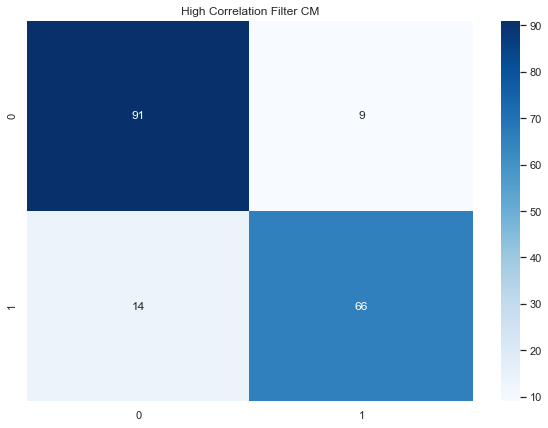

In [39]:
start_time = time.time()

#Perform predictions on new reduced dataset and find best model parameters

y_preds_corr, cm_corr, fpr_corr, tpr_corr, accuracy_corr, _, trains_corr, tests_corr = predict(X_corr, y, LOGO, groups)

mean_acc_corr = np.mean(accuracy_corr)

std_acc_corr = np.std(accuracy_corr)

plt.figure(figsize = (10,7))

plt.title("High Correlation Filter CM")

sns.heatmap(cm_corr, annot=True,cmap="Blues")

scores_corr = get_scores(cm_corr, y_preds_corr)

scores_corr[0] = mean_acc_corr

scores_corr[1] = std_acc_corr

execution_time = time.time() - start_time

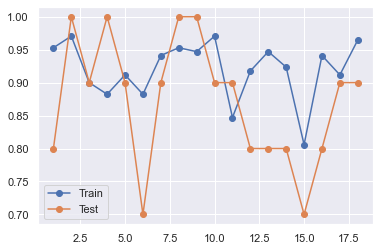

In [40]:
#Plot train and test scores on method
values = [i for i in range(1, 19)]
plt.plot(values, trains_corr, '-o', label='Train')
plt.plot(values, tests_corr, '-o', label='Test')
plt.legend()
plt.show()

In [41]:
#Add results to aggregating table
scores_corr.append(execution_time)
scores_corr.append(X_corr.shape[1])
results_final["High Correlation Filter"] = scores_corr

In [42]:
#We can see that this filter enhances the performance
results_final

,Baseline,High Correlation Filter
Accuracy Mean,0.855556,0.872222
Accuracy Std,0.125708,0.093128
Specificity,0.855263,0.880000
Sensitivity,0.855769,0.866667
AUC Score,0.851250,0.867500
Execution Time (s),6.067074,2.572357
Number of Features,432.000000,350.000000


<b>Method 2:</b> Mutual Information Filter

In [43]:
#After applying the high correlation filter, we will use the Mutual Information to select the k best features
#We will use GridSearch to find the best k to use

start_time = time.time()

#Since mutual information was computationally expensive, finding the best SGD classifer parameters would take too long.
#Hence, we used the baseline model's parameters to filter out unecessary features.

X_mutual, _ = filter(X, y, groups, mutual_info_classif, LOGO, model_base)

execution_time = time.time() - start_time

360 Features
Best Parameters: {'alpha': 0.09}
Train accuracy: 0.9215686274509804
Test accuracy: 0.8666666666666667


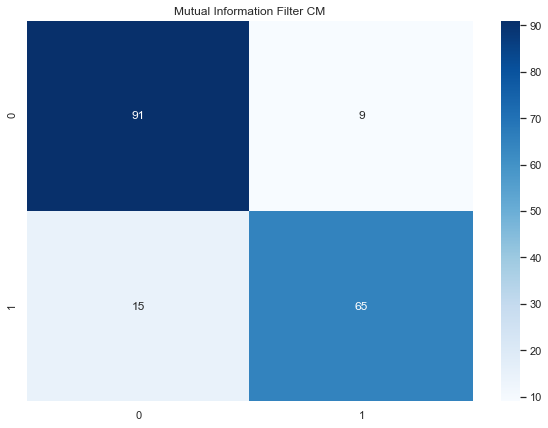

In [44]:
#Test the mutual info method

model_mutual = deepcopy(model_base)

#Use the same baseline model for predictions.

y_preds_mi, cm_mi, fpr_mi, tpr_mi, accuracy_mi, _, trains_mi, tests_mi = predict(X_mutual, y, LOGO, groups)

mean_acc_mi = np.mean(accuracy_mi)

std_acc_mi = np.std(accuracy_mi)

plt.figure(figsize = (10,7))
    
plt.title("Mutual Information Filter CM")

sns.heatmap(cm_mi, annot=True,cmap="Blues")

scores_mutual = get_scores(cm_mi, y_preds_mi)

scores_mutual[0] = mean_acc_mi

scores_mutual[1] = std_acc_mi

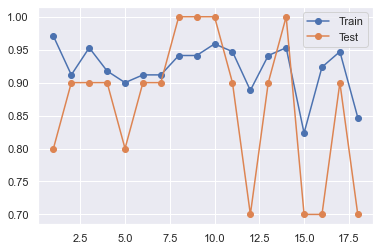

In [45]:
#Plot train and test scores on method
values = [i for i in range(1, 19)]
plt.plot(values, trains_mi, '-o', label='Train')
plt.plot(values, tests_mi, '-o', label='Test')
plt.legend()
plt.show()

In [46]:
#Add results to aggregating table
scores_mutual.append(execution_time)
scores_mutual.append(X_mutual.shape[1])
results_final["Mutual Information Filter"] = scores_mutual

In [47]:
#This method is computationally expensive without a big increase in performance.
results_final

,Baseline,High Correlation Filter,Mutual Information Filter
Accuracy Mean,0.855556,0.872222,0.866667
Accuracy Std,0.125708,0.093128,0.105409
Specificity,0.855263,0.880000,0.878378
Sensitivity,0.855769,0.866667,0.858491
AUC Score,0.851250,0.867500,0.861250
Execution Time (s),6.067074,2.572357,209.172318
Number of Features,432.000000,350.000000,360.000000


<b>Method 3:</b> ANOVA Filter (f-Test)

In [48]:
#After applying the high correlation filter, we will use the ANOVA (f-Test) to select the k best features
#We will use GridSearch to find the best k to use

start_time = time.time()

#Find the best model parameters and reduce the data using Anova.

X_anova, alpha_anova = filter(X, y, groups, f_classif, LOGO)

print(f"Best model parameters: {alpha_anova}")

execution_time = time.time() - start_time

300 features
Best model parameters: 0.009


300 Features
Train accuracy: 0.9732026143790848
Test accuracy: 0.9055555555555556


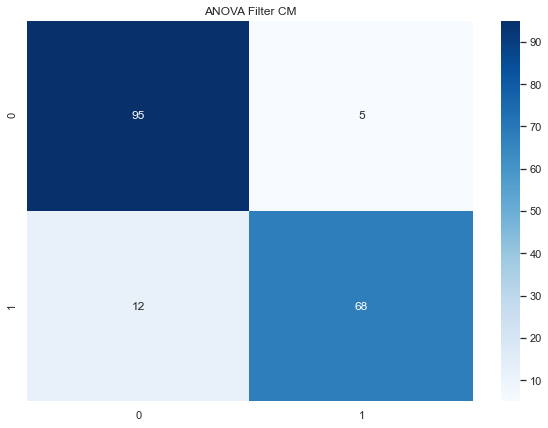

In [49]:
#Test the Anova method

cv_1 = LOGO.split(deepcopy(X_anova), y, groups)

#Use the best model parameters that fit the reduced data best for predictions

model_anova = SGDClassifier(early_stopping=False, n_iter_no_change=3,loss = "modified_huber",
                               tol=0.0001, validation_fraction=0.2,alpha=alpha_anova,random_state=42, n_jobs=-1)

y_preds_anova, cm_anova, fpr_anova, tpr_anova, accuracy_anova, _, trains_anova, tests_anova = predict(X_anova, 
                                                                                                      y, 
                                                                                                      LOGO,
                                                                                                      groups, 
                                                                                                      model_anova)

mean_acc_anova = np.mean(accuracy_anova)

std_acc_anova = np.std(accuracy_anova)

plt.figure(figsize = (10,7))

plt.title("ANOVA Filter CM")

sns.heatmap(cm_anova, annot=True,cmap="Blues")

scores_anova = get_scores(cm_anova, y_preds_anova)

scores_anova[0] = mean_acc_anova

scores_anova[1] = std_acc_anova

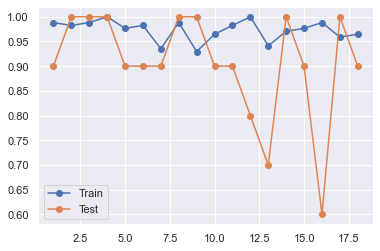

In [50]:
#Plot train and test scores on method
values = [i for i in range(1, 19)]
plt.plot(values, trains_anova, '-o', label='Train')
plt.plot(values, tests_anova, '-o', label='Test')
plt.legend()
plt.show()

In [51]:
#Add results to aggregating table
scores_anova.append(execution_time)
scores_anova.append(X_anova.shape[1])
results_final["Anova (f-Test) Filter"] = scores_anova

In [52]:
#Notice better performance with ANOVA
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter
Accuracy Mean,0.855556,0.872222,0.866667,0.905556
Accuracy Std,0.125708,0.093128,0.105409,0.107869
Specificity,0.855263,0.880000,0.878378,0.931507
Sensitivity,0.855769,0.866667,0.858491,0.887850
AUC Score,0.851250,0.867500,0.861250,0.900000
Execution Time (s),6.067074,2.572357,209.172318,24.790698
Number of Features,432.000000,350.000000,360.000000,300.000000


<b>Part 2:</b> Wrapper Methods

<b>Method 1</b>: Recursive Elimination with Cross Validation

161 Features
Best Parameters: {'alpha': 0.006}
Train accuracy: 0.9568627450980389
Test accuracy: 0.9277777777777779


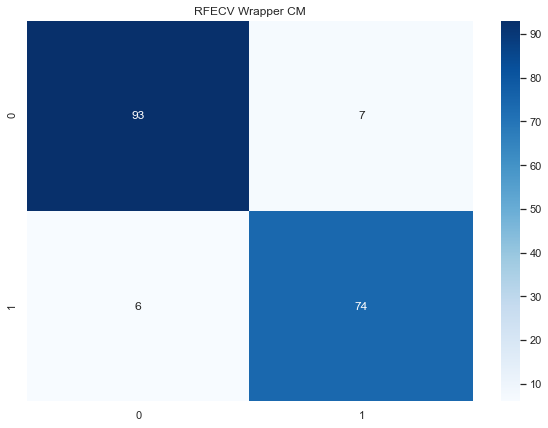

In [53]:
start_time = time.time()

LOGO = LeaveOneGroupOut()

cv_0 = LOGO.split(X, y, groups)

#FInd optimal features using cross validation

rfecv = RFECV(estimator=model_base, min_features_to_select=1, cv=cv_0,n_jobs=-1)

#reduce dataset

X_rfe = rfecv.fit_transform(X,y)

#Perform predictions on new features by finding best model parameters 

y_preds_rfe, cm_rfe, fpr_rfe, tpr_rfe, accuracy_rfe, _, trains_rfe, tests_rfe = predict(X_rfe,
                                                                                        y, 
                                                                                        LOGO,
                                                                                        groups)
mean_acc_rfe = np.mean(accuracy_rfe)

std_acc_rfe = np.std(accuracy_rfe)

plt.figure(figsize = (10,7))

plt.title("RFECV Wrapper CM")

sns.heatmap(cm_rfe, annot=True,cmap="Blues")

scores_rfecv = get_scores(cm_rfe, y_preds_rfe)

scores_rfecv[0] = mean_acc_rfe

scores_rfecv[1] = std_acc_rfe

execution_time = time.time() - start_time

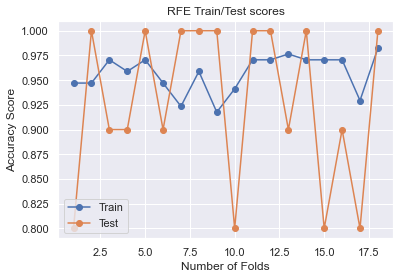

In [75]:
#plot train and test scores on method
values = [i for i in range(1, 19)]
plt.plot(values, trains_rfe, '-o', label='Train')
plt.plot(values, tests_rfe, '-o', label='Test')
plt.legend(loc = "lower left")
plt.title("RFE Train/Test scores")
plt.xlabel("Number of Folds")
plt.ylabel("Accuracy Score")
plt.show()

In [54]:
#append resullts in aggregating table
scores_rfecv.append(execution_time)
scores_rfecv.append(rfecv.n_features_)
results_final["RFECV"] = scores_rfecv

In [55]:
#A big increase in metric scores with the RFE method, and an unexpected execution time.
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter,RFECV
Accuracy Mean,0.855556,0.872222,0.866667,0.905556,0.927778
Accuracy Std,0.125708,0.093128,0.105409,0.107869,0.080316
Specificity,0.855263,0.880000,0.878378,0.931507,0.913580
Sensitivity,0.855769,0.866667,0.858491,0.887850,0.939394
AUC Score,0.851250,0.867500,0.861250,0.900000,0.927500
Execution Time (s),6.067074,2.572357,209.172318,24.790698,20.713762
Number of Features,432.000000,350.000000,360.000000,300.000000,161.000000


<b>Part 2:</b> Embedded Methods

<b>Method 1:</b> Ridge Regression

175 Features
Best Parameters: {'alpha': 1}
Train accuracy: 0.9526143790849672
Test accuracy: 0.8777777777777778


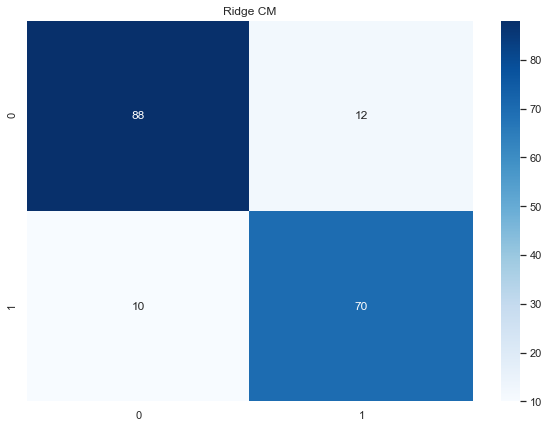

In [56]:
start_time = time.time()

#Extract best features from Ridge model

selection = SelectFromModel(Ridge(alpha=0.001,random_state=42))

selection.fit(X, y)

# see the selected features.
selected_features = features.columns[(selection.get_support())]

cols = []

for f in selected_features:
    cols.append(f)

X_ridge = features[selected_features]

#perform predictions on new selected features while finding best model parameters that suit it best

y_preds_ridge, cm_ridge, fpr_ridge, tpr_ridge, accuracy_ridge, _,trains_ridge,tests_ridge = predict(X_ridge.values, 
                                                                                                    y, 
                                                                                                    LOGO, 
                                                                                                    groups)

mean_acc_ridge = np.mean(accuracy_ridge)

std_acc_ridge = np.std(accuracy_ridge)

plt.figure(figsize = (10,7))

plt.title("Ridge CM")

sns.heatmap(cm_ridge, annot=True,cmap="Blues")

scores_ridge = get_scores(cm_ridge, y_preds_ridge)

scores_ridge[0] = mean_acc_ridge

scores_ridge[1] = std_acc_ridge

execution_time = time.time() - start_time

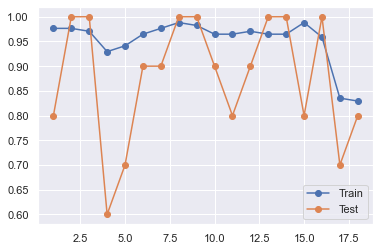

In [73]:
#Plot train test scores on method
values = [i for i in range(1, 19)]
plt.plot(values, trains_ridge, '-o', label='Train')
plt.plot(values, tests_ridge, '-o', label='Test')
plt.legend()
plt.show()

In [58]:
#Append metrics in aggregating table
scores_ridge.append(execution_time)
scores_ridge.append(X_ridge.shape[1])
results_final["Ridge"] = scores_ridge

In [59]:
#Ridge method does not support the increase in performance but is fast in execution time.
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter,RFECV,Ridge
Accuracy Mean,0.855556,0.872222,0.866667,0.905556,0.927778,0.877778
Accuracy Std,0.125708,0.093128,0.105409,0.107869,0.080316,0.122726
Specificity,0.855263,0.880000,0.878378,0.931507,0.913580,0.853659
Sensitivity,0.855769,0.866667,0.858491,0.887850,0.939394,0.897959
AUC Score,0.851250,0.867500,0.861250,0.900000,0.927500,0.877500
Execution Time (s),6.067074,2.572357,209.172318,24.790698,20.713762,1.327449
Number of Features,432.000000,350.000000,360.000000,300.000000,161.000000,175.000000


<b>Method 2:</b> Lasso Regression

136 Features
Best Parameters: {'alpha': 0.009}
Train accuracy: 0.9316993464052289
Test accuracy: 0.911111111111111


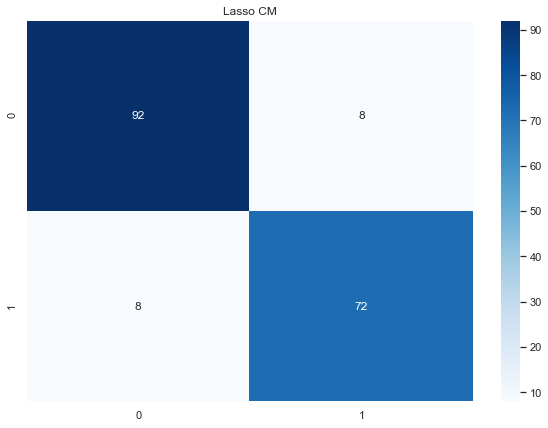

In [60]:
start_time = time.time()

alpha_optimal = 0.002

#Extract best features from Lasso model

selection = SelectFromModel(Lasso(alpha = alpha_optimal, random_state=42))

selection.fit(X, y)

# see the selected features.
selected_features = features.columns[(selection.get_support())]

cols = []

for f in selected_features:
    cols.append(f)

X_lasso = features[selected_features]

#perform predictions on new selected features while finding best model parameters that suit it best

y_preds_lasso, cm_lasso, fpr_lasso, tpr_lasso, accuracy_lasso, _,trains_lasso, tests_lasso = predict(X_lasso.values, 
                                                                                                     y, 
                                                                                                     LOGO, 
                                                                                                     groups)

mean_acc_lasso = np.mean(accuracy_lasso)

std_acc_lasso = np.std(accuracy_lasso)

plt.figure(figsize = (10,7))

plt.title("Lasso CM")

sns.heatmap(cm_lasso, annot=True,cmap="Blues")

scores_lasso = get_scores(cm_lasso, y_preds_lasso)

scores_lasso[0] = mean_acc_lasso

scores_lasso[1] = std_acc_lasso

execution_time = time.time() - start_time

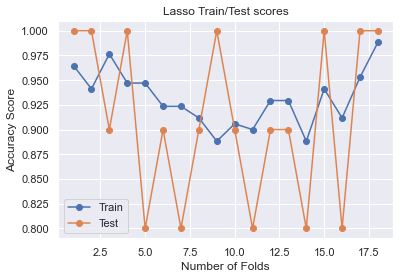

In [69]:
#Plot train test scores on method
values = [i for i in range(1, 19)]
plt.plot(values, trains_lasso, '-o', label='Train')
plt.plot(values, tests_lasso, '-o', label='Test')
plt.legend()
plt.title("Lasso Train/Test scores")
plt.xlabel("Number of Folds")
plt.ylabel("Accuracy Score")
plt.show()

In [62]:
scores_lasso.append(execution_time)
scores_lasso.append(X_lasso.shape[1])
results_final["Lasso"] = scores_lasso

In [63]:
#Huge increase in performance and very short execution time
results_final

,Baseline,High Correlation Filter,Mutual Information Filter,Anova (f-Test) Filter,RFECV,Ridge,Lasso
Accuracy Mean,0.855556,0.872222,0.866667,0.905556,0.927778,0.877778,0.911111
Accuracy Std,0.125708,0.093128,0.105409,0.107869,0.080316,0.122726,0.080890
Specificity,0.855263,0.880000,0.878378,0.931507,0.913580,0.853659,0.900000
Sensitivity,0.855769,0.866667,0.858491,0.887850,0.939394,0.897959,0.920000
AUC Score,0.851250,0.867500,0.861250,0.900000,0.927500,0.877500,0.910000
Execution Time (s),6.067074,2.572357,209.172318,24.790698,20.713762,1.327449,1.252481
Number of Features,432.000000,350.000000,360.000000,300.000000,161.000000,175.000000,136.000000


In [64]:
results_final.to_csv('Methods_Scores.csv')  #Uncomment if file does not exist

In [65]:
#Prepare roc curves
roc_curves_plot = [[fpr_base,tpr_base],[fpr_corr,tpr_corr],[fpr_mi,tpr_mi],
                   [fpr_anova,tpr_anova],[fpr_rfe,tpr_rfe],
                   [fpr_ridge,tpr_ridge],[fpr_lasso,tpr_lasso]]

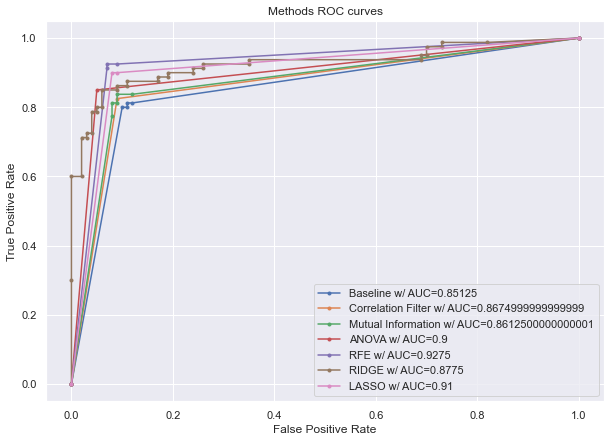

In [66]:
#Plot ROC curves of every method at every threshold
idx = 0
legends = ["Baseline","Correlation Filter","Mutual Information","ANOVA","RFE","RIDGE","LASSO"]
auc_scores = results_final.loc["AUC Score"]
plt.figure(figsize=(10,7))
for roc in roc_curves_plot:
    label = legends[idx] + " w/ AUC="+str(auc_scores[idx])
    plt.plot(roc[0][:],roc[1][:],marker='.',label = label)
    idx+=1
plt.title("Methods ROC curves")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_results.png')

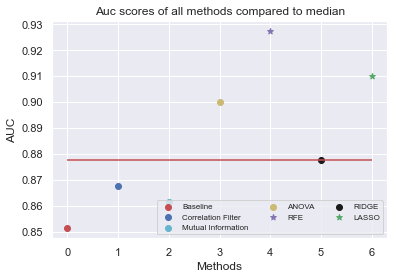

In [67]:
#Plot auc scores of all methods and compare against each other and median score (horizontal line in red)
auc_scores = results_final.loc["AUC Score",:]
legends = ["Baseline","Correlation Filter","Mutual Information","ANOVA","RFE","RIDGE","LASSO"]
mean_auc = np.median(auc_scores)
colors = ['b', 'c', 'y', 'm', 'g','k','m']
x = np.linspace(0,6,7)
ax.set_facecolor('w')
m0 = plt.scatter(x[0],auc_scores[0],color = 'r')
m1 = plt.scatter(x[1],auc_scores[1],color = colors[0])
m2 = plt.scatter(x[2],auc_scores[2],color = colors[1])
m3 = plt.scatter(x[3],auc_scores[3],color = colors[2])
m4 = plt.scatter(x[4],auc_scores[4],color = colors[3],marker="*")
m5 = plt.scatter(x[5],auc_scores[5],color = colors[5])
m6 = plt.scatter(x[6],auc_scores[6],color = colors[4],marker="*")
plt.legend((m0,m1,m2,m3,m4,m5,m6),
           (legends),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)
plt.ylabel('AUC')
plt.xlabel("Methods")
plt.title("Auc scores of all methods compared to median")
plt.hlines(mean_auc,min(x),max(x),'r')
plt.savefig('results_graph.png')